In [1]:
%matplotlib notebook

%matplotlib ipympl

import numpy as np
import h5py
import matplotlib.pyplot as plt

from ipywidgets import *

from geohelper import geohelper

In [2]:
from sklearn.neighbors import NearestNeighbors

In [22]:
class neighbor_finder:
    """Find out nearest neighbors
    """
    def __init__(self):
        self.points = np.array([])
        self.finder = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    def load_points(self, points):
        self.points = points
    def find_k_neighbors(self, points, k):
        if k > 1:
            self.finder = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
        elif k <=0:
            raise NotImplementedError("k must be non-negative")
        self.finder.fit(self.points)
        distances, indices = self.finder.kneighbors(points)
        return distances, indices

In [4]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [5]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
print(sync_mask.shape)
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

(48479011,)
1201  packet groups partitioned by sync packets


In [24]:
def interactive_plot_adc(sync_group, counter, threshold):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    threshold: minimum of threshold within a time duration
    """

    plt.close('all')

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')


    t0 = physics_bins[counter]*bin_width
    t1 = physics_bins[counter]*bin_width+bin_width

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp


    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    ############
    plt.ioff()
    fig3d = plt.figure('event display & ADC sum', figsize=(16, 8))
    ax3d = fig3d.add_subplot(121, projection='3d')
    axslice = fig3d.add_subplot(122)

    figproj = plt.figure('projection of event display', figsize=(16, 16))
    axty = figproj.add_subplot(223)
    axxy = figproj.add_subplot(224)
    axtx = figproj.add_subplot(221)
    
    fig2 = plt.figure('ADC sum of single channels', figsize=(8, 5))
    axadc = fig2.add_subplot(111)

    # plt.ion()
    
    def plot_3d():
        ax3d.clear()
        ax3d.scatter(timestamp, x, y, s=1)
        ax3d.set_xlabel("Timestamp [0.1 us]")
        ax3d.set_ylabel("x []", labelpad=10)
        ax3d.set_zlabel("y []")
        plt.tight_layout()
        fig3d.canvas.draw_idle()
        fig3d.canvas.flush_events()

    def update_range(updatebutton):
        plot_adc_slice()
        plot_proj()

    def plot_adc_slice():
        axslice.clear()
        x0, x1 = ax3d.get_xlim()
        y0, y1 = ax3d.get_ylim()
        z0, z1 = ax3d.get_zlim()
        # print("x range:", y0, y1, "[]")
        # print("y range:", z0, z1, "[]")
        # print("t range:", x0, x1, "[]")
        t0 = x0
        t1 = x1

        adcmask = (timestamp > x0) & (timestamp < x1) & (x > y0) & (x < y1) & (y > z0) & (y < z1)

        nbins = 50
        counts, bins = np.histogram(timestamp[adcmask], bins=nbins, range=(t0, t1), weights=dataword[adcmask])
        axslice.stairs(counts, bins)
        
        axslice.set_ylabel("ADC sum per {} [0.1 us]".format((t1-t0)/nbins))
        axslice.set_xlabel("Timestamp [0.1 us]")
        
        fig3d.canvas.draw_idle()
        fig3d.canvas.flush_events()

    def plot_proj():
        t0, t1 = ax3d.get_xlim()
        x0, x1 = ax3d.get_ylim()
        y0, y1 = ax3d.get_zlim()
        axtx.clear()
        axty.clear()
        axxy.clear()

        axtx.set_xlim(t0, t1)
        axtx.set_ylim(x0, x1)
        axty.set_xlim(t0, t1)
        axty.set_ylim(y0, y1)
        axxy.set_xlim(x0, x1)
        axxy.set_ylim(y0, y1)

        axtx.set_xlabel('timestamp [0.1 us]')
        axtx.set_ylabel('x []')
        axty.set_xlabel('timestamp [0.1 us]')
        axty.set_ylabel('y []')
        axxy.set_xlabel('x []')
        axxy.set_ylabel('y []')

        adcmask = (timestamp > t0) & (timestamp < t1) & (x > x0) & (x < x1) & (y > y0) & (y < y1)
        
        # axtx.scatter(timestamp[adcmask], x[adcmask], marker='o', c=dataword[adcmask])
        # axty.scatter(timestamp[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        # axxy.scatter(x[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        axtx.scatter(timestamp[adcmask], x[adcmask], marker='o')
        axty.scatter(timestamp[adcmask], y[adcmask], marker='o')
        axxy.scatter(x[adcmask], y[adcmask], marker='o')
        figproj.canvas.draw_idle()
        figproj.canvas.flush_events()

 
    k_w = widgets.IntSlider(value=1, min=1, max=10, description='k nearest points', layout={"width": '500px'})
    trange_w = widgets.FloatRangeSlider(value=(t0, t1), min=t0, max=t1, description="time stamp min", layout={"width": '500px'})
    points_w = widgets.TagsInput(
        value=[],
        allow_duplicates = False
    )
    def plot_adc(trange, k=1, points=[]):
        axadc.clear()

        tmin = trange[0]
        tmax = trange[1]

        # adcmask = (timestamp > t0) & (timestamp < t1) & dataword > 0
        adcmask = (timestamp > t0) & (timestamp < t1) & (dataword > 0)
        xtemp = x[adcmask]
        ytemp = y[adcmask]
        xyvalid = np.stack([xtemp, ytemp]).transpose()

        xyvalid = np.unique(xyvalid, axis=0)
        
        nearestxy = neighbor_finder()
        nearestxy.load_points(xyvalid)
    
        nbins = 50
    
        counts = []
        labels = []

        for p in points:
            try:
                (i, j) = p.split(',')
                i = float(i.strip())
                j = float(j.strip())
                # print(i, j)
                distances, indices = nearestxy.find_k_neighbors([[i, j]], k=k)
                for idx in indices[0]:
                    xvalid, yvalid = xyvalid[idx]
                    tileid, chipid, channelid = helper.find_ids(xvalid, yvalid)
                    labels.append("({:.1f},{:.1f})->({:.1f},{:.1f})->{}:{}:{}".format(i, j, xvalid, yvalid, tileid, chipid, channelid))
                    idmask = (tile_id == tileid) & (chip_id == chipid) & (channel_id == channelid)
                    h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
                    # print(h, bins)
                    counts.append(h)
                    axadc.stairs(h, bins, label=labels[-1])
            except ValueError:
                continue

        axadc.set_ylabel("ADC sum per {} [0.1 us]".format(bin_width/nbins))
        axadc.set_xlabel("Timestamp [0.1 us]")
        if labels:
            axadc.legend()
        fig2.canvas.draw_idle()
        fig2.canvas.flush_events()

    plot_3d()
    plot_adc_slice()
    plot_proj()
    
    button = widgets.Button(description="Update ADC sum in range", layout={"width": '500px'}) 
    output = widgets.Output()

    # middle_plot = interactive_output(plot_adc_slice, {"updatebutton": button})

    button.on_click(update_range)

    interactive_plot = interactive_output(plot_adc, {"trange" : trange_w, "k" : k_w, "points" : points_w})

    display(button, output)

    fig3d.show()
    figproj.show()
    display(widgets.VBox([points_w, trange_w, k_w]), interactive_plot)
    fig2.show()
    

27352  data packets between syncs
12  candidate events
1724  hits in event


Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

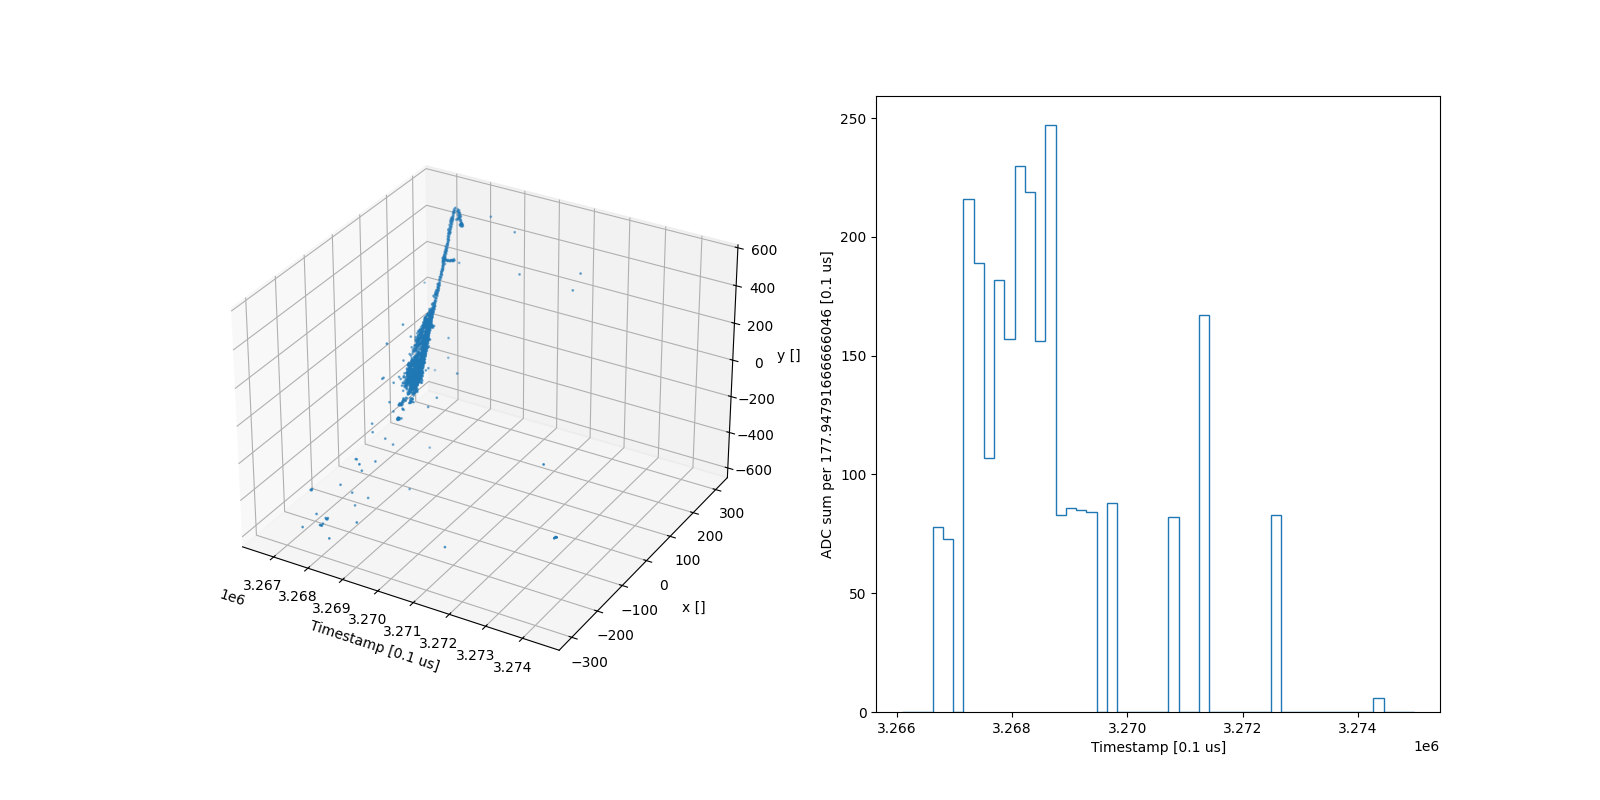

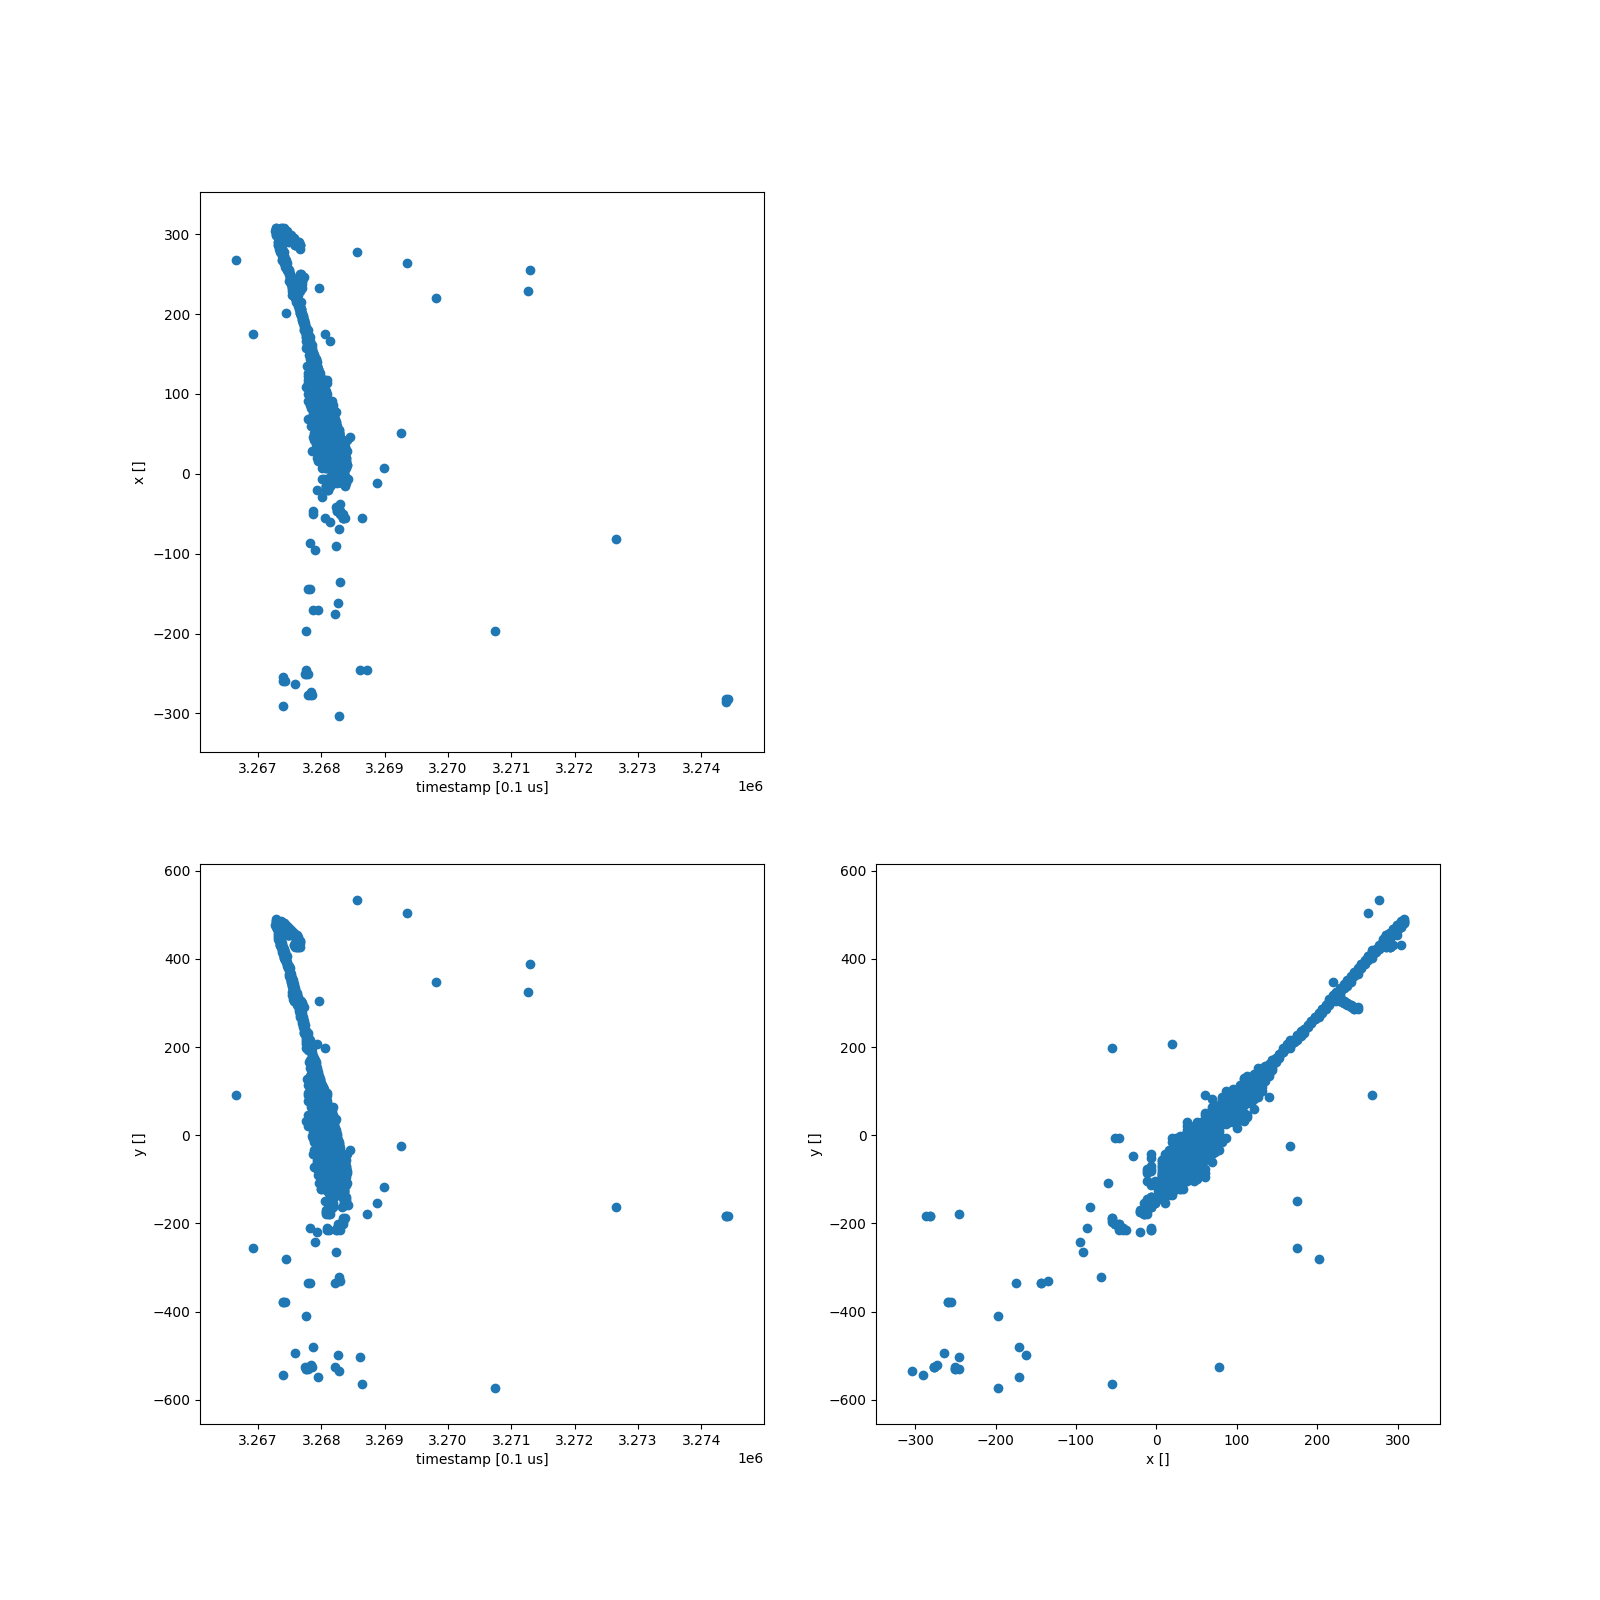

Output()

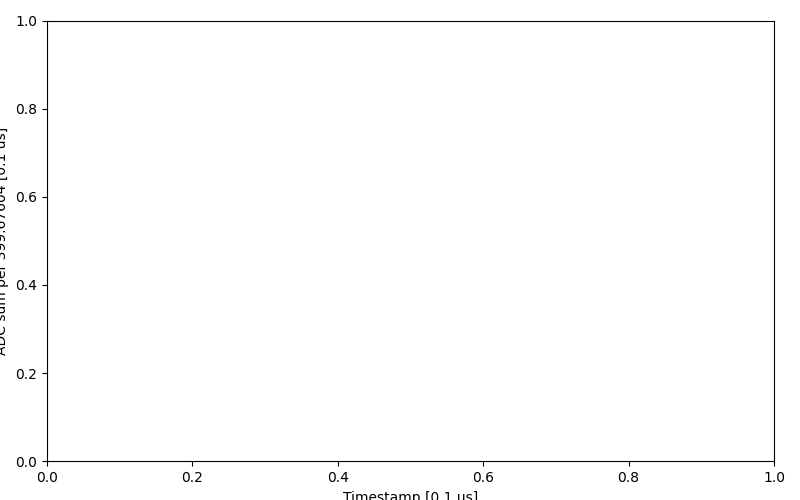

In [25]:
interactive_plot_adc(2, 4, 500)